<a href="https://colab.research.google.com/github/shakedoren1/ObjectDetection/blob/main/Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#VGG16

Setting up the code environment:

In [1]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions

In [2]:
model = VGG16(weights='imagenet')
print(model.summary())

553467096/553467096 [==============================] - 12s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                           

Getting the Oxford-IIIT Pet Dataset:

In [3]:
%%capture
!wget https://thor.robots.ox.ac.uk/datasets/pets/images.tar.gz
!wget https://thor.robots.ox.ac.uk/datasets/pets/annotations.tar.gz
!tar -xvzf images.tar.gz && tar -xvzf annotations.tar.gz
!rm  images/*.mat

making a mapping of labels:

In [93]:
image_files = os.listdir('images/')

def extract_breed(filename):
    # This regex pattern matches the last underscore followed by any number of digits and the file extension
    pattern = re.compile(r'(.+)_\d+\.jpg$')
    match = pattern.match(filename)
    if match:
        # Extract the breed name, replace underscores with spaces for readability
        breed_name = match.group(1).replace('_', ' ')
        # Capitalize the first letter of each word
        return breed_name
    else:
        # Return None or a default value if the filename doesn't match the pattern
        return None

# Create a dictionary mapping filenames to formatted breed names
label_mapping = {file: extract_breed(file) for file in image_files if extract_breed(file) is not None}

In [5]:
# Convert the dictionary values to a set to get unique labels
unique_labels = set(label_mapping.values())

# Convert the set to a list and sort it
sorted_labels = sorted(list(unique_labels))

# Print the count of unique labels
print(f"Number of unique labels: {len(sorted_labels)}")

# Iterate through the sorted list and print each unique label
for label in sorted_labels:
    print(label)

Number of unique labels: 37
Abyssinian
Bengal
Birman
Bombay
British Shorthair
Egyptian Mau
Maine Coon
Persian
Ragdoll
Russian Blue
Siamese
Sphynx
american bulldog
american pit bull terrier
basset hound
beagle
boxer
chihuahua
english cocker spaniel
english setter
german shorthaired
great pyrenees
havanese
japanese chin
keeshond
leonberger
miniature pinscher
newfoundland
pomeranian
pug
saint bernard
samoyed
scottish terrier
shiba inu
staffordshire bull terrier
wheaten terrier
yorkshire terrier


In [6]:
breed_to_vgg16_mapping = {
    'Abyssinian': ('cat', None), # No corresponding label in VGG16
    'Bengal': ('cat', None),
    'Birman': ('cat', None),
    'Bombay': ('cat', None),
    'British Shorthair': ('cat', None),
    'Egyptian Mau': ('cat', 'Egyptian_cat'),
    'Maine Coon': ('cat', None),
    'Persian': ('cat', 'Persian_cat'),
    'Ragdoll': ('cat', None),
    'Russian Blue': ('cat', None),
    'Siamese': ('cat', 'Siamese_cat'),
    'Sphynx': ('cat', None),

    'american bulldog': ('dog', None),
    'american pit bull terrier': ('dog', None),
    'basset hound': ('dog', 'basset'),
    'beagle': ('dog', 'beagle'),
    'boxer': ('dog', 'boxer'),
    'chihuahua': ('dog', 'Chihuahua'),
    'english cocker spaniel': ('dog', 'cocker_spaniel'),
    'english setter': ('dog', 'English_setter'),
    'german shorthaired': ('dog', 'German_short-haired_pointer'),
    'great pyrenees': ('dog', 'Great_Pyrenees'),
    'havanese': ('dog', None),
    'japanese chin': ('dog', 'Japanese_spaniel'),
    'keeshond': ('dog', 'keeshond'),
    'leonberger': ('dog', 'Leonberg'),
    'miniature pinscher': ('dog', 'miniature_pinscher'),
    'newfoundland': ('dog', 'Newfoundland'),
    'pomeranian': ('dog', 'Pomeranian'),
    'pug': ('dog', 'pug'),
    'saint bernard': ('dog', 'Saint_Bernard'),
    'samoyed': ('dog', 'Samoyed'),
    'scottish terrier': ('dog', None),
    'shiba inu': ('dog', None),
    'staffordshire bull terrier': ('dog', 'Staffordshire_bullterrier'),
    'wheaten terrier': ('dog', 'soft-coated_wheaten_terrier'),
    'yorkshire terrier': ('dog', 'Yorkshire_terrier'),
}

In [14]:
vgg16_to_breed_mapping = {
    'Egyptian_cat' : ('cat', 'Egyptian Mau'),
    'Persian_cat' : ('cat', 'Persian'),
    'tiger_cat' : ('cat', None), # No corresponding label in dataset
    'Siamese_cat' : ('cat', 'Siamese'),
    'tabby' : ('cat', None),
    'English_setter' : ('dog', 'english setter'),
    'Siberian_husky' : ('dog', None),
    'Australian_terrier' : ('dog', None),
    'English_springer' : ('dog', None),
    'malamute' : ('dog', None),
    'Great_Dane' : ('dog', None),
    'Walker_hound' : ('dog', None),
    'Welsh_springer_spaniel' : ('dog', None),
    'whippet' : ('dog', None),
    'Scottish_deerhound' : ('dog', None),
    'Weimaraner' : ('dog', None),
    'soft-coated_wheaten_terrier' : ('dog', 'wheaten terrier'),
    'Dandie_Dinmont' : ('dog', None),
    'Old_English_sheepdog' : ('dog', None),
    'otterhound' : ('dog', None),
    'bloodhound' : ('dog', None),
    'Airedale' : ('dog', None),
    'giant_schnauzer' : ('dog', None),
    'dalmatian' : ('dog', None),
    'black-and-tan_coonhound' : ('dog', None),
    'papillon' : ('dog', None),
    'Staffordshire_bullterrier' : ('dog', 'staffordshire bull terrier'),
    'Mexican_hairless' : ('dog', None),
    'Bouvier_des_Flandres' : ('dog', None),
    'miniature_poodle' : ('dog', None),
    'malinois' : ('dog', None),
    'Lhasa' : ('dog', None),
    'Yorkshire_terrier' : ('dog', 'yorkshire terrier'),
    'Newfoundland' : ('dog', 'newfoundland'),
    'Norwegian_elkhound' : ('dog', None),
    'Rottweiler' : ('dog', None),
    'Saluki' : ('dog', None),
    'schipperke' : ('dog', None),
    'Pekinese' : ('dog', None),
    'Brabancon_griffon' : ('dog', None),
    'West_Highland_white_terrier' : ('dog', None),
    'Sealyham_terrier' : ('dog', None),
    'Irish_wolfhoundr' : ('dog', None),
    'EntleBucher' : ('dog', None),
    'French_bulldog' : ('dog', None),
    'basenji' : ('dog', None),
    'Bernese_mountain_dog' : ('dog', None),
    'Maltese_dog' : ('dog', None),
    'Norfolk_terrier' : ('dog', None),
    'toy_terrier' : ('dog', None),
    'vizsla' : ('dog', None),
    'cairn' : ('dog', None),
    'groenendael' : ('dog', None),
    'clumber' : ('dog', None),
    'komondor' : ('dog', None),
    'Afghan_hound' : ('dog', None),
    'Japanese_spaniel' : ('dog', 'japanese chin'),
    'borzoi' : ('dog', None),
    'toy_poodle' : ('dog', None),
    'Kerry_blue_terrier' : ('dog', None),
    'Scotch_terrier' : ('dog', None),
    'Tibetan_mastiff' : ('dog', None),
    'Doberman' : ('dog', None),
    'Boston_bull' : ('dog', None),
    'Greater_Swiss_Mountain_dog' : ('dog', None),
    'Appenzeller' : ('dog', None),
    'Shih-Tzu' : ('dog', None),
    'Irish_water_spaniel' : ('dog', None),
    'miniature_schnauzer' : ('dog', None),
    'collie' : ('dog', None),
    'affenpinscher' : ('dog', None),
    'Pomeranian' : ('dog', 'pomeranian'),
    'Bedlington_terrier' : ('dog', None),
    'golden_retriever' : ('dog', None),
    'Irish_terrier' : ('dog', None),
    'Border_collie' : ('dog', None),
    'boxer' : ('dog', None),
    'silky_terrier' : ('dog', None),
    'beagle' : ('dog', None),
    'Leonberg' : ('dog', None),
    'German_short-haired_pointer' : ('dog', 'german shorthaired'),
    'Chesapeake_Bay_retriever' : ('dog', None),
    'bull_mastiff' : ('dog', None),
    'kuvasz' : ('dog', None),
    'pug' : ('dog', 'pug'),
    'curly-coated_retriever' : ('dog', None),
    'Norwich_terrier' : ('dog', None),
    'flat-coated_retriever' : ('dog', None),
    'keeshond' : ('dog', 'keeshond'),
    'Eskimo_dog' : ('dog', None),
    'Brittany_spaniel' : ('dog', None),
    'standard_poodle' : ('dog', None),
    'Lakeland_terrier' : ('dog', None),
    'Gordon_setter' : ('dog', None),
    'dingo' : ('dog', None),
    'standard_schnauzer' : ('dog', None),
    'Tibetan_terrier' : ('dog', None),
    'wire-haired_fox_terrier' : ('dog', None),
    'basset' : ('dog', 'basset hound'),
    'chow' : ('dog', None),
    'American_Staffordshire_terrier' : ('dog', None),
    'Shetland_sheepdog' : ('dog', None),
    'Great_Pyrenees' : ('dog', 'great pyrenees'),
    'Chihuahua' : ('dog', 'chihuahua'),
    'Labrador_retriever' : ('dog', None),
    'Saint_Bernard' : ('dog', 'saint bernard'),
    'Samoyed' : ('dog', 'samoyed'),
    'bluetick' : ('dog', None),
    'redbone' : ('dog', None),
    'kelpie' : ('dog', None),
    'miniature_pinscher' : ('dog',   'miniature pinscher'),
    'Italian_greyhound' : ('dog', None),
    'cocker_spaniel' : ('dog', 'english cocker spaniel'),
    'Irish_setter' : ('dog', None),
    'Sussex_spaniel' : ('dog', None),
    'Pembroke' : ('dog', None),
    'Blenheim_spaniel' : ('dog', None),
    'Rhodesian_ridgeback' : ('dog', None),
    'briard' : ('dog', None),
    'Border_terrier' : ('dog', None),
    'German_shepherd' : ('dog', None)
}

## One random picture:

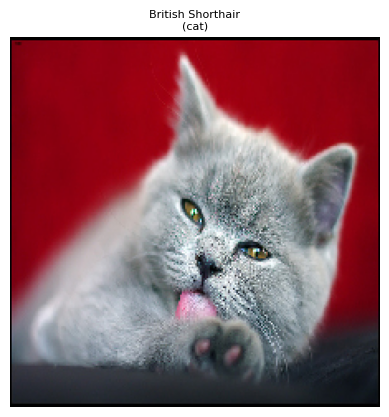

In [32]:
# Choosing one random picture
random_file = np.random.choice(os.listdir('annotations/xmls/'))
img_name = f'{random_file[:-4]}.jpg'
label = label_mapping[img_name]
img = image.load_img('images/'+img_name, target_size=(224, 224))
# Determine if the image is a dog or a cat using the breed_to_vgg16_mapping
animal_type, _ = breed_to_vgg16_mapping.get(label, (None, None))

plt.imshow(img)
plt.title(f"{label}\n({animal_type})", fontsize=8)
plt.axis('off')
plt.show()

In [33]:
# Predicting that one picture
img_array = image.img_to_array(img)
img_array_expanded_dims = np.expand_dims(img_array, axis=0)
preprocessed_img = preprocess_input(img_array_expanded_dims)
predictions = model.predict(preprocessed_img)
decoded_predictions = decode_predictions(predictions, top=3)[0]

# Determine the actual animal type and specific VGG16 label (if any) for the breed
actual_animal_type, actual_vgg16_label = breed_to_vgg16_mapping.get(label, (None, None))

# Prepare message about the breed's presence in VGG16
breed_presence_message = "This breed is recognized by VGG16." if actual_vgg16_label else "This breed is not specifically recognized by VGG16."

print(breed_presence_message)

for i, (imagenet_id, predicted_label, score) in enumerate(decoded_predictions):
    # Determine the animal type of the predicted label
    predicted_animal_type, _ = vgg16_to_breed_mapping.get(predicted_label, (None, None))
    animal_type_text = f"({predicted_animal_type})" if predicted_animal_type else "(Unknown animal type)"

    # Check accuracy
    if actual_vgg16_label:
        accuracy_text = " ---- correct breed" if predicted_label == actual_vgg16_label else " ---- wrong breed"
    else:
        # If breed is not recognized by VGG16, check if animal type is correct
        accuracy_text = " ---- correct animal type" if predicted_animal_type == actual_animal_type else " ---- wrong animal type"

    print(f"{i + 1}: {predicted_label} {animal_type_text} ({score:.2f}){accuracy_text}")


1/1 [==============================] - 1s 1s/step
This breed is not specifically recognized by VGG16.
1: Persian_cat (cat) (0.57) ---- correct animal type
2: lynx (Unknown animal type) (0.16) ---- wrong animal type
3: remote_control (Unknown animal type) (0.06) ---- wrong animal type


## 30 random pictures:

Selecting 30 random pictures from the dataset:

In [86]:
filenames = os.listdir('annotations/xmls/')
selected_files = np.random.choice(filenames, size=30, replace=False)

Prepare the images and labels for display:

In [87]:
images = []
labels = []
for file in selected_files:
    img_filename = f'{file[:-4]}.jpg'
    if img_filename in label_mapping:
        img = image.load_img('images/' + img_filename, target_size=(224, 224))
        images.append(img)
        labels.append(label_mapping[img_filename])

Display images in a 6x5 grid with labels:

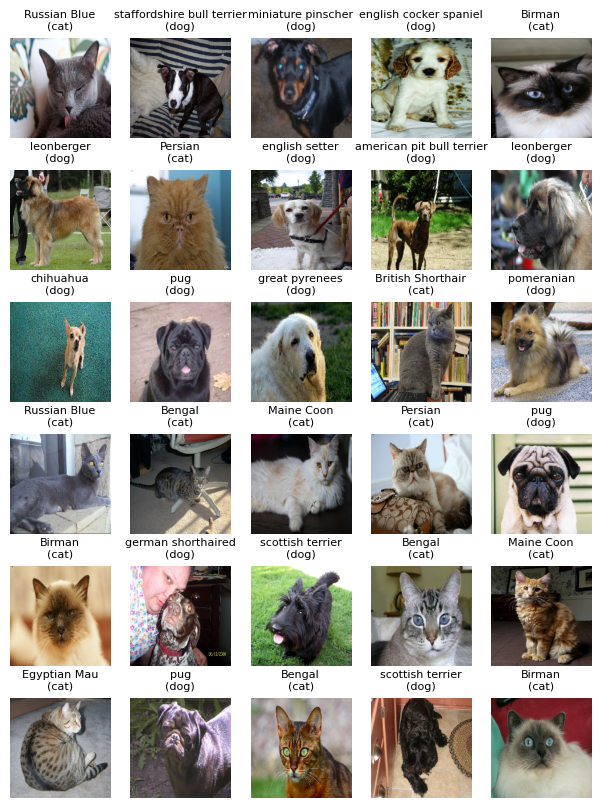

In [88]:
plt.figure(figsize=(7.5, 10))
for i, (img, label) in enumerate(zip(images, labels)):
    # Determine if the image is a dog or a cat using the breed_to_vgg16_mapping
    animal_type, _ = breed_to_vgg16_mapping.get(label, (None, None))

    plt.subplot(6, 5, i+1)
    plt.imshow(img)
    plt.title(f"{label}\n({animal_type})", fontsize=8)
    plt.axis('off')
plt.show()

Process images and predict:

In [89]:
predictions = []
for img in images:
    img_array = img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    preprocessed_img = preprocess_input(img_array_expanded_dims)
    preds = model.predict(preprocessed_img)
    predictions.append(decode_predictions(preds, top=1)[0][0])

1/1 [==============================] - 1s 528ms/step


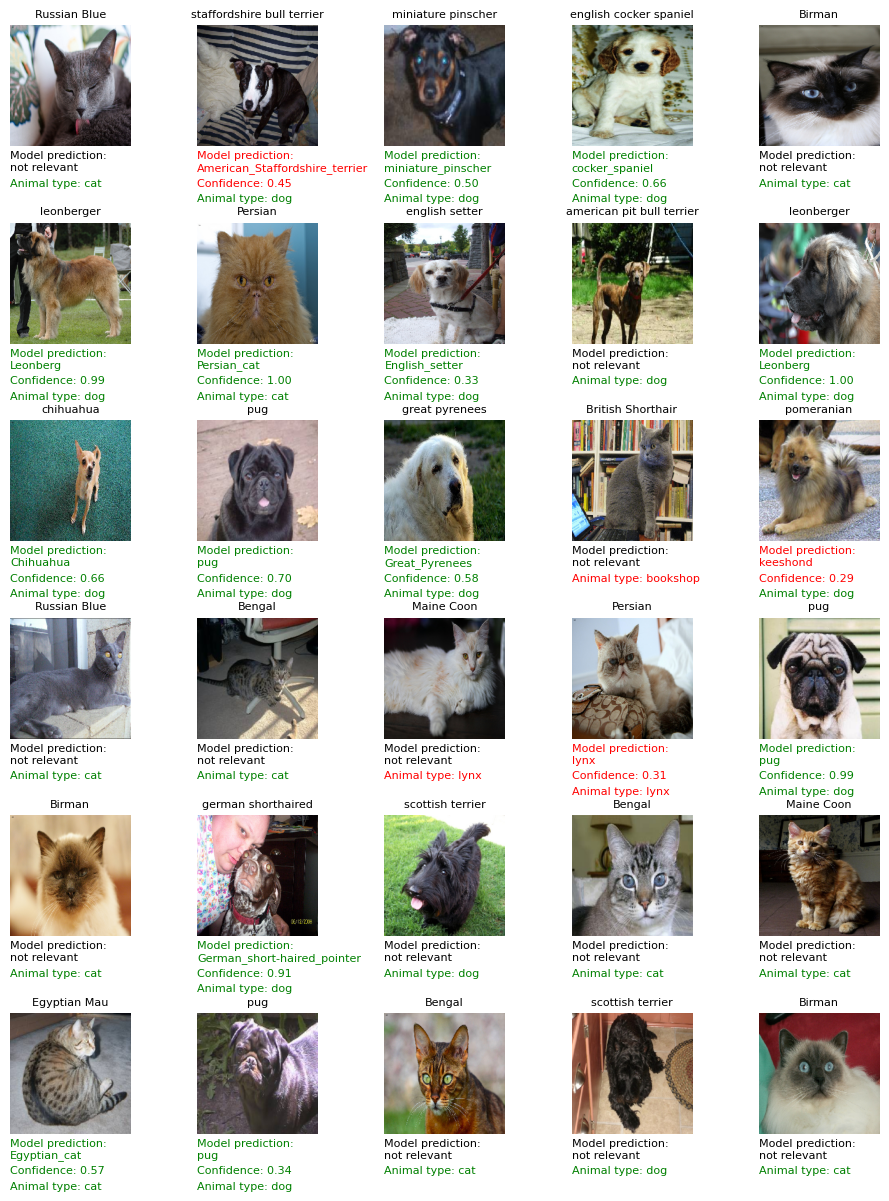

In [90]:
# Initialize counts
correct_breed_predictions_count = 0
correct_animal_type_predictions_count = 0
relevant_predictions_count = 0

# Display predictions
plt.figure(figsize=(9, 12))
for i, (img, label, pred) in enumerate(zip(images, labels, predictions)):
    plt.subplot(6, 5, i + 1)
    plt.imshow(img)
    plt.axis('off')

    # Extract the predicted VGG16 breed label and its confidence score
    predicted_vgg16_label, confidence = pred[1], pred[2]

    # Determine actual and predicted animal type and breed
    actual_animal_type, actual_vgg16_label = breed_to_vgg16_mapping.get(label, (None, None))
    predicted_animal_type, predicted_breed = vgg16_to_breed_mapping.get(predicted_vgg16_label, (None, None))
    if not predicted_animal_type:
      predicted_animal_type = predicted_vgg16_label

    # Check if the breed prediction matches the actual breed based on the mapping
    is_relevant = actual_vgg16_label is not None
    is_correct_breed = (actual_vgg16_label == predicted_vgg16_label)
    is_correct_animal_type = (actual_animal_type == predicted_animal_type)

    # Update correct predictions count based on relevance and correctness
    if is_relevant:
        relevant_predictions_count += 1
    if is_correct_breed:
        correct_breed_predictions_count += 1
    if is_correct_animal_type:
        correct_animal_type_predictions_count += 1

    plt.title(label, fontsize=8)

    # Show not relevant instead of prediction if there's no corresponding VGG16 label
    type_pred_color = 'green' if is_correct_animal_type else 'red'
    if not is_relevant:
        plt.text(0, -0.2, "Model prediction:\nnot relevant", fontsize=8, transform=plt.gca().transAxes)
        plt.text(0, -0.33, f"Animal type: {predicted_animal_type}", fontsize=8, color=type_pred_color, transform=plt.gca().transAxes)
    else:
        # Prediction in green or red
        breed_pred_color = 'green' if is_correct_breed else 'red'
        plt.text(0, -0.2, f"Model prediction:\n{predicted_vgg16_label}", fontsize=8, color=breed_pred_color, transform=plt.gca().transAxes)
        plt.text(0, -0.33, f"Confidence: {confidence:.2f}", fontsize=8, color=breed_pred_color, transform=plt.gca().transAxes)
        plt.text(0, -0.46, f"Animal type: {predicted_animal_type}", fontsize=8, color=type_pred_color, transform=plt.gca().transAxes)

plt.tight_layout()
plt.show()

In [92]:
# Calculate percentages
breed_accuracy_percentage = (correct_breed_predictions_count / relevant_predictions_count) * 100 if relevant_predictions_count > 0 else 0
animal_type_accuracy_percentage = (correct_animal_type_predictions_count / len(predictions)) * 100 if len(predictions) > 0 else 0

# Print summary with percentages
print(f"Correct breed predictions (relevant only): {correct_breed_predictions_count}/{relevant_predictions_count} ({breed_accuracy_percentage:.2f}%)")
print(f"Correct animal type predictions: {correct_animal_type_predictions_count}/{len(predictions)} ({animal_type_accuracy_percentage:.2f}%)")


Correct breed predictions (relevant only): 13/16 (81.25%)
Correct animal type predictions: 27/30 (90.00%)
